# Machine Learning Final Project

## Importing Libraries

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import scipy
import nbformat

from sklearn.preprocessing import LabelBinarizer, PolynomialFeatures, LabelEncoder, StandardScaler
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
import sklearn.metrics
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

# Preliminary Data Analysis

Load in the training and test data.

In [2]:
#training data
train = pd.read_csv("train.csv")
print(train.head()) #print the first few rows
print("Train shape: ")
print(train.shape) #look at the shape of the training data

#test data test
test = pd.read_csv("test.csv")
print(test.head()) #print the first few rows
print("Test shape: ")
print(test.shape) #look at the shape of the test data

   Unnamed: 0 Kingdom  DNAtype  SpeciesID  Ncodons  \
0         872     vrl        0     207343     6686   
1        9865     inv        0       7629    10060   
2        3190     bct        0     320850    14031   
3        3674     bct        0       1397    39839   
4       11372     vrt        1      50790     5112   

                            SpeciesName      UUU      UUC      UUA      UUG  \
0                    Bovine foamy virus  0.01541  0.00927  0.01720  0.01825   
1              Anthocidaris crassispina  0.01213  0.02515  0.00268  0.01352   
2               Staphylococcus phage X2  0.02580  0.01618  0.03606  0.01354   
3                    Bacillus circulans  0.00128  0.02141  0.01225  0.01649   
4  mitochondrion Dascyllus trimaculatus  0.03169  0.01780  0.03893  0.00000   

   ...      CGG      AGA      AGG      GAU      GAC      GAA      GAG  \
0  ...  0.00643  0.02064  0.01182  0.02812  0.00838  0.03365  0.01974   
1  ...  0.00268  0.00915  0.01412  0.03280  0.02555  0

### Data pre processing
There should be a total of 69/68 columns: 67 attributes (64/63 codons, SpeciesName, SpeciesID, and Ncodons) and 2 specifying the classification of the sample (Kingdom and DNAtype). The amount of columns for codons differs because the column for the AGA codon is missing in the test data. There's seems to be an additional column in the train and test object (Unnamed: 0), which I remove here. I also remove columns SpeciesName and SpeciesID, becuase they are unique to each row and therefore not meaningful to the problem.

In [3]:
train=train.drop(columns='Unnamed: 0') #drop the specified columns
train=train.drop(columns='SpeciesName')
train=train.drop(columns='SpeciesID')
print(train.head())
test=test.drop(columns='Unnamed: 0') #drop the specified columns
test=test.drop(columns='SpeciesName')
test=test.drop(columns='SpeciesID')
print(test.head())

  Kingdom  DNAtype  Ncodons      UUU      UUC      UUA      UUG      CUU  \
0     vrl        0     6686  0.01541  0.00927  0.01720  0.01825  0.01436   
1     inv        0    10060  0.01213  0.02515  0.00268  0.01352  0.01372   
2     bct        0    14031  0.02580  0.01618  0.03606  0.01354  0.00848   
3     bct        0    39839  0.00128  0.02141  0.01225  0.01649  0.01330   
4     vrt        1     5112  0.03169  0.01780  0.03893  0.00000  0.06240   

       CUC      CUA  ...      CGG      AGA      AGG      GAU      GAC  \
0  0.02303  0.01555  ...  0.00643  0.02064  0.01182  0.02812  0.00838   
1  0.01143  0.00775  ...  0.00268  0.00915  0.01412  0.03280  0.02555   
2  0.02067  0.01041  ...  0.00114  0.01775  0.00499  0.03756  0.02523   
3  0.01308  0.00399  ...  0.01177  0.00705  0.00422  0.03316  0.02229   
4  0.01056  0.05262  ...  0.00000  0.00000  0.00000  0.00020  0.01389   

       GAA      GAG      UAA      UAG      UGA  
0  0.03365  0.01974  0.01511  0.00030  0.00030  
1  0.0

*Note:* Although the columns Ncodons could be included as a feature, the goal of this project is to use codon frequencies to perform prediction, so I chose to exclude it as a feature, since it is not a codon frequency but rather the total number codons.

In [4]:
train=train.drop(columns='Ncodons')
print(train.head())
test=test.drop(columns='Ncodons')
print(test.head())

  Kingdom  DNAtype      UUU      UUC      UUA      UUG      CUU      CUC  \
0     vrl        0  0.01541  0.00927  0.01720  0.01825  0.01436  0.02303   
1     inv        0  0.01213  0.02515  0.00268  0.01352  0.01372  0.01143   
2     bct        0  0.02580  0.01618  0.03606  0.01354  0.00848  0.02067   
3     bct        0  0.00128  0.02141  0.01225  0.01649  0.01330  0.01308   
4     vrt        1  0.03169  0.01780  0.03893  0.00000  0.06240  0.01056   

       CUA      CUG  ...      CGG      AGA      AGG      GAU      GAC  \
0  0.01555  0.02094  ...  0.00643  0.02064  0.01182  0.02812  0.00838   
1  0.00775  0.02992  ...  0.00268  0.00915  0.01412  0.03280  0.02555   
2  0.01041  0.00278  ...  0.00114  0.01775  0.00499  0.03756  0.02523   
3  0.00399  0.02834  ...  0.01177  0.00705  0.00422  0.03316  0.02229   
4  0.05262  0.01408  ...  0.00000  0.00000  0.00000  0.00020  0.01389   

       GAA      GAG      UAA      UAG      UGA  
0  0.03365  0.01974  0.01511  0.00030  0.00030  
1  0.0

Next I check to see if there is any missing data. The project specification says that aside from the missing AGA column of the test data, there should not be any missing data, so this acts as a sanity check to ensure the data is as intended.

In [5]:
#check how many samples with missing values there are in
(pd.isna(train).sum()>0).sum() #the train data
(pd.isna(test).sum()>0).sum() #and the test data

0

0

Here I take the train and test data and split into X, containing the features, and y_kingdom and y_dnatype, containing the classifications.

In [6]:
X_features=['UUU', 'UUC', 'UUA', 'UUG', 'CUU', 'CUC', 'CUA', 'CUG', 'AUU', 'AUC', 'AUA',
       'AUG', 'GUU', 'GUC', 'GUA', 'GUG', 'GCU', 'GCC', 'GCA', 'GCG', 'CCU',
       'CCC', 'CCA', 'CCG', 'UGG', 'GGU', 'GGC', 'GGA', 'GGG', 'UCU', 'UCC',
       'UCA', 'UCG', 'AGU', 'AGC', 'ACU', 'ACC', 'ACA', 'ACG', 'UAU', 'UAC',
       'CAA', 'CAG', 'AAU', 'AAC', 'UGU', 'UGC', 'CAU', 'CAC', 'AAA', 'AAG',
       'CGU', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG', 'GAU', 'GAC', 'GAA', 'GAG',
       'UAA', 'UAG', 'UGA'] #all the feature columns present in the training data
X_train=train[X_features] #put in our X for training only the columns containing features
X_train.shape #verify that there are now 64 columns

X_features.remove('AGA') #remove the AGA column since it is not present in the test data
X_test=test[X_features] #put in our X for test only the columns containing features
X_test.shape #verify that there are now 63 columns

#grab the columns containing the classification data
y_train_kingdom=train['Kingdom']
y_train_dnatype=train['DNAtype']
y_test_kingdom=test['Kingdom']
y_test_dnatype=test['DNAtype']


(10422, 64)

(2606, 63)

Here, I use LabelBinarizer to represent the classifications as one-hot encodings.

In [7]:
# Convert kingdom into a one-hot encoding
lbk=LabelBinarizer()
y_train_kingdom_onehot = lbk.fit_transform(y_train_kingdom)
y_test_kingdom_onehot = lbk.fit_transform(y_test_kingdom)
# Convert dnatype into a one-hot encoding
lbd=LabelBinarizer()
y_train_dnatype_onehot = lbd.fit_transform(y_train_dnatype)
y_test_dnatype_onehot = lbd.fit_transform(y_test_dnatype)
y_train_kingdom_onehot

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

*Note:* The DNA type class ranges from 0 to 12, but values 8 and 10 are missing from the entire data set, so in the one hot encoding index 8 corresponds to type 9, index 9 corresponds to type 11, and and index 10 corresponds to type 12.

## Data Visualization
Here I use the training data including the classifications to produce a heatmap to visualize the correlations between aspects of the data. Although it would be possible to also produce a pair plot, due to the amount of features I chose not to.

<Figure size 1500x1500 with 0 Axes>

<Axes: >

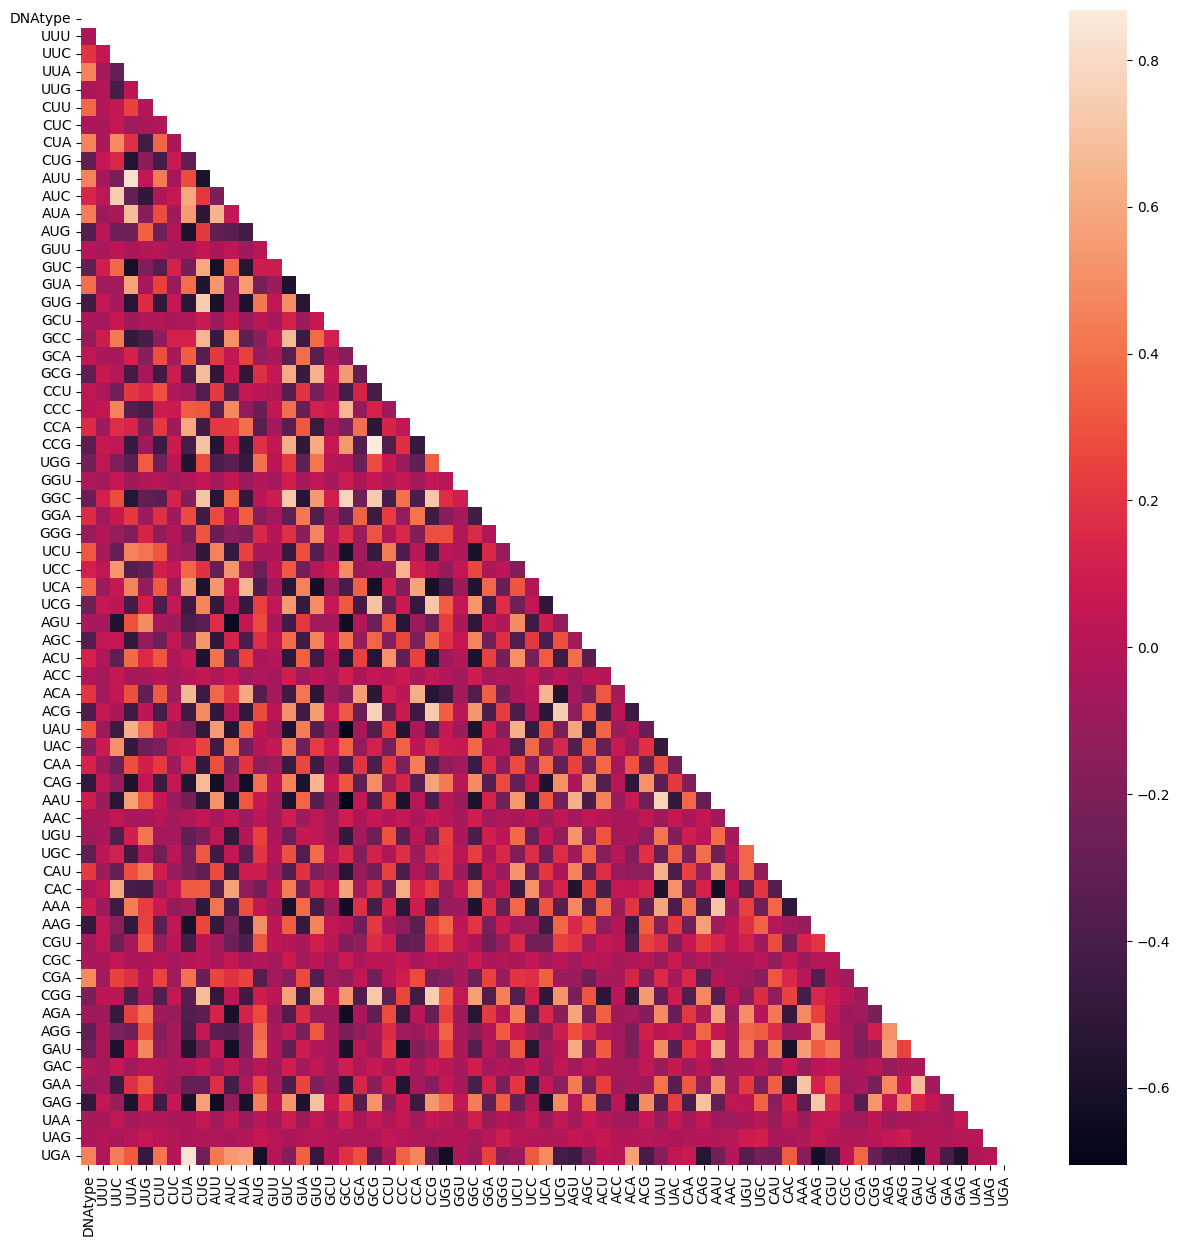

<Figure size 1500x1500 with 0 Axes>

<Axes: >

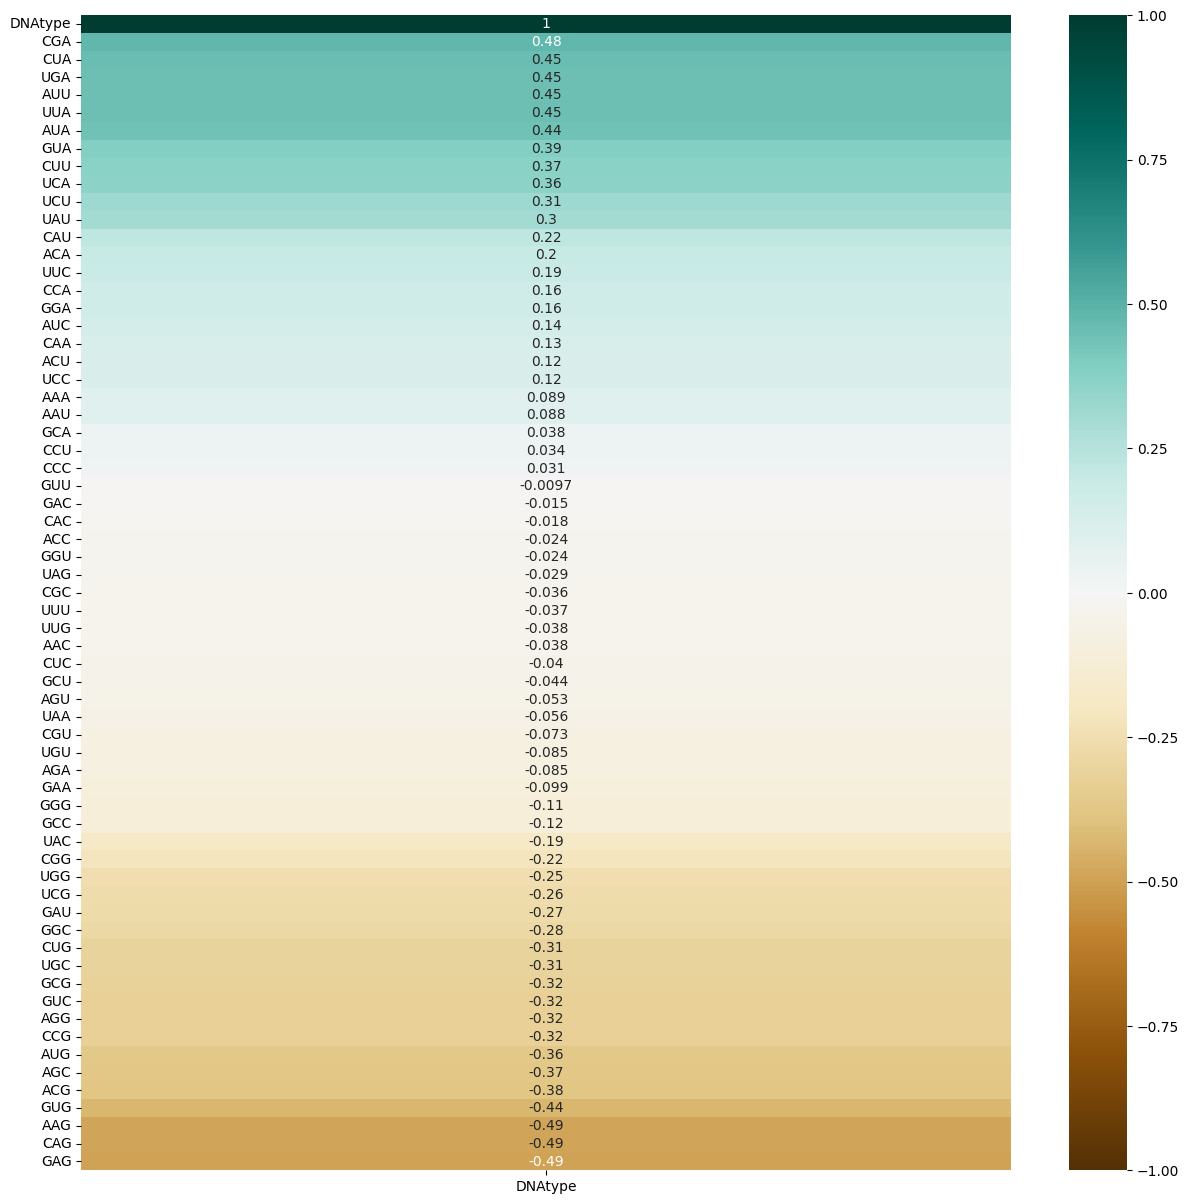

<Figure size 1500x1500 with 0 Axes>

<Axes: >

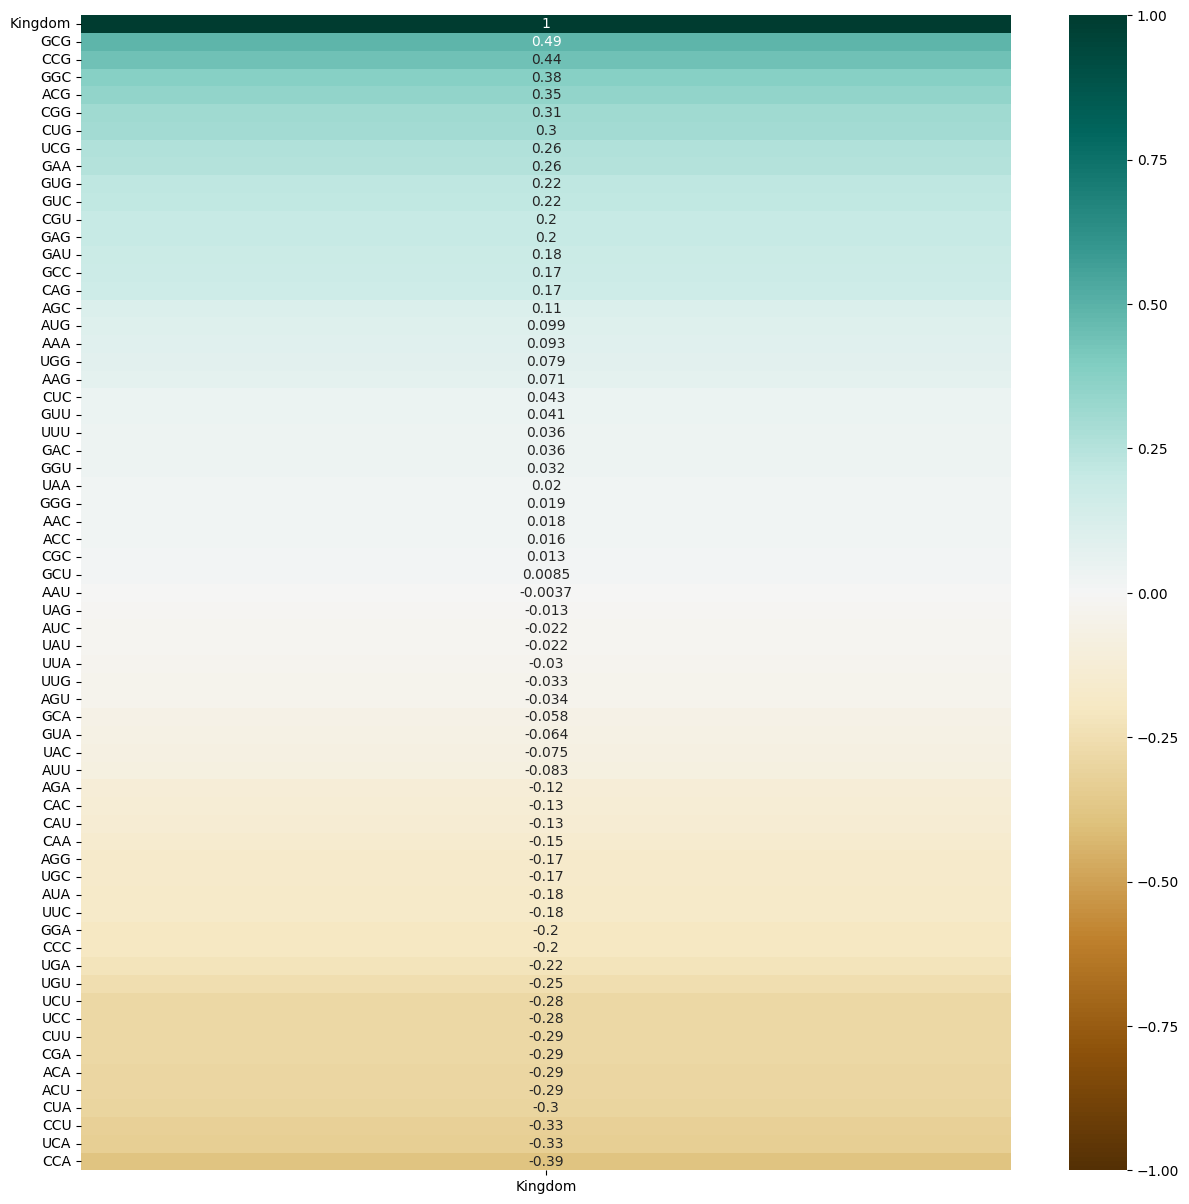

In [8]:
corr = train.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
#display the heatmap
plt.figure(figsize=(15,15))
sns.heatmap(corr, mask=mask)
plt.show()
#display the correlation specifically for DNA type
plt.figure(figsize=(15,15))
sns.heatmap(train.corr(numeric_only=True)[['DNAtype']].sort_values(by='DNAtype', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.show()
#create a temporary integer representation of the Kingdom class using the binary one hot encoding for the purposes of displaying the correlation
yfig=[]
def binatodeci(binary):
    return sum(val*(2**idx) for idx, val in enumerate(reversed(binary)))
yfig=np.apply_along_axis(binatodeci, 1, y_train_kingdom_onehot)
xycombo=X_train.assign(Kingdom=yfig)
#display the correlation specifically for kingdom
plt.figure(figsize=(15,15))
sns.heatmap(xycombo.corr(numeric_only=True)[['Kingdom']].sort_values(by='Kingdom', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.show()

Here I plot the frequency of the DNA type classifications in the data. The train and test data seems to follow the same distribution, but there is a high bias towards one classification, which will likely have an impact on the classification models, and encourage them to favor prediction of the class that has the most samples.

array([[   0,    1,    2,    3,    4,    5,    6,    7,    9,   11,   12],
       [7407, 2320,  658,    2,   24,    1,    1,    1,    2,    1,    5]])

(array([9.727e+03, 6.580e+02, 2.000e+00, 2.400e+01, 1.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 6.000e+00]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <BarContainer object of 10 artists>)

array([[   0,    1,    2,    4,    5,   11],
       [1860,  579,  158,    7,    1,    1]])

(array([2.439e+03, 1.580e+02, 0.000e+00, 7.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <BarContainer object of 10 artists>)

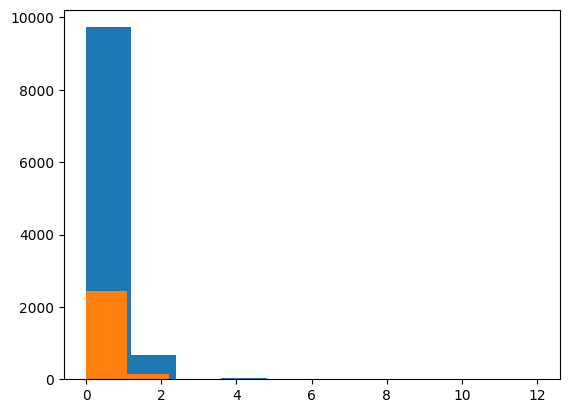

In [9]:
np.asarray(np.unique(train['DNAtype'], return_counts=True))
plt.hist(train['DNAtype'], label="Train")
np.asarray(np.unique(test['DNAtype'], return_counts=True))
plt.hist(test['DNAtype'], label="test")

To account for these severely skewed classes, I group DNA type classes 2 through 12 into one class.

<ipython-input-10-b3617b7c2ab1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_dnatype.loc[y_train_dnatype>1,]=2
<ipython-input-10-b3617b7c2ab1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_dnatype.loc[y_test_dnatype>1,]=2


array([[   0,    1,    2],
       [7407, 2320,  695]])

(array([7407.,    0.,    0.,    0.,    0., 2320.,    0.,    0.,    0.,
         695.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

array([[   0,    1,    2],
       [1860,  579,  167]])

(array([1860.,    0.,    0.,    0.,    0.,  579.,    0.,    0.,    0.,
         167.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

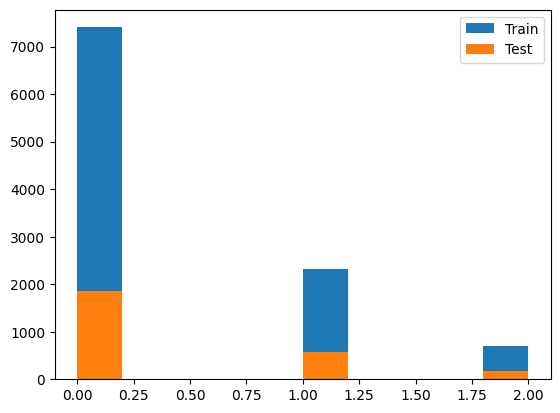

In [10]:
y_train_dnatype.loc[y_train_dnatype>1,]=2
y_test_dnatype.loc[y_test_dnatype>1,]=2
#also apply this change to the one hot encodings
y_train_dnatype_onehot = lbd.fit_transform(y_train_dnatype)
y_test_dnatype_onehot = lbd.fit_transform(y_test_dnatype)

np.asarray(np.unique(y_train_dnatype, return_counts=True))
plt.hist(y_train_dnatype, label="Train")
np.asarray(np.unique(y_test_dnatype, return_counts=True))
plt.hist(y_test_dnatype, label="Test")
plt.legend()

Here I plot the frequency of the Kingdom classifications in the data. The train and test data seems to again follow the same distribution, but the classifications are more likely across samples, although there is some bias towards certain classifications over others, it is not as severe as for DNA type.

array([['arc', 'bct', 'inv', 'mam', 'phg', 'plm', 'pln', 'pri', 'rod',
        'vrl', 'vrt'],
       [101, 2336, 1076, 458, 176, 14, 2018, 144, 172, 2265, 1662]],
      dtype=object)

(array([2265., 1076., 2336., 1662., 2018.,  101.,  172.,  458.,  176.,
         158.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

array([['arc', 'bct', 'inv', 'mam', 'phg', 'plm', 'pln', 'pri', 'rod',
        'vrl', 'vrt'],
       [25, 584, 269, 114, 44, 4, 505, 36, 43, 567, 415]], dtype=object)

(array([567., 269., 584., 415., 505.,  25.,  43., 114.,  44.,  40.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

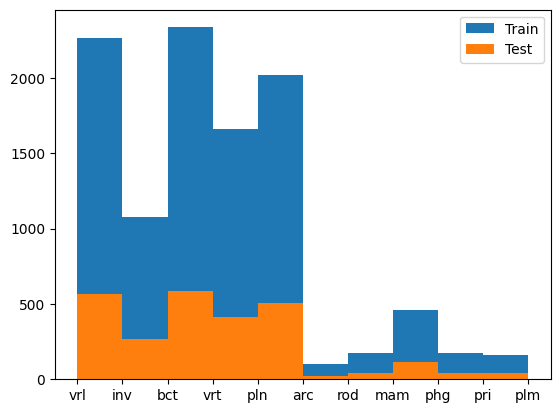

In [11]:
np.asarray(np.unique(train['Kingdom'], return_counts=True))
plt.hist(train['Kingdom'], label="Train")
np.asarray(np.unique(test['Kingdom'], return_counts=True))
plt.hist(test['Kingdom'], label="Test")
plt.legend()

### Dimensionality Reduction for Visualization
Here I used TSNE to reduce the dimensions of the data down to 3, and then visualized the data colored by Kingdom and DNA type.

In [12]:
tsne = TSNE(n_components=3, random_state=0)
projections = tsne.fit_transform(X_train, )

fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=train['Kingdom'], labels={'color': 'Kingdom'}
)
fig.update_traces(marker_size=8)

In [13]:
fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=y_train_dnatype, labels={'color': 'DNAtype'}
)
fig.update_traces(marker_size=8)

## Clustering Analysis
Here, I use hierarchical clustering, Kmeans clustering, and DBSCAN to see how the data clusters. Although sillouhette score could be used to estimate the clusters, it is already known from the data that there are 11 kingdoms and 11 DNA types, so the number of clusters should be set to 11 to best represent that. It should be noted, generally, that due to the high number of dimensions present the results may not be ideal.

### Clustering Metrics
Here, I define the functions to evaluate the performance of the clustering algorithms, given that the true values of y are known.

In [14]:
def get_Ncounts(y_predict, y_true, X, k, j=None):
    #N is the total number of samples
    N = X.shape[0]
    #Nk is the total number of samples in cluster k
    Nk_mask = y_predict==k
    Nk = Nk_mask.sum()
    Nj, Nkj = None, None
    #if we have a label
    if j is not None:
        Nj_mask = y_true==j
        Nj = Nj_mask.sum()
        #samples that are both in cluster k and with label j
        Nkj = np.logical_and(Nk_mask, Nj_mask).sum()
    return N, Nk, Nj, Nkj

#computing precision
def precision(y_predict, y_true, X, k, j):
    N, Nk, Nj, Nkj = get_Ncounts(y_predict, y_true, X, k, j)
    return Nkj / (Nk + 1e-8)


#computing purity
def purity(y_predict, y_true, X, k):
    cls = np.unique(y_true)
    prec = [precision(y_predict, y_true, X, k, j) for j in cls]
    return max(prec)

def tot_purity(y_predict, y_true, X): #interpreted as a sort of accuracy in terms of clustering
    N = y_true.shape[0]
    nc = len(np.unique(y_true))
    p = 0
    for k in range(nc):
        N, Nk, _, _ = get_Ncounts(y_predict, y_true, X, k)
        pk = purity(y_predict, y_true, X, k)
        p += (Nk / N) * pk
    return p

### Hierarchical Clustering
First I define a function to plot the dendrograms resulting from hierarchical clustering.

In [15]:
def plot_dendrogram(Z=None, model=None, X=None, **kwargs):
    annotate_above = kwargs.pop('annotate_above', 0)

    # this block Reconstruct the linakge matrix if the standard model API was used
    if Z is None:
        if hasattr(model, 'distances_') and model.distances_ is not None:
            # create the counts of samples under each node
            counts = np.zeros(model.children_.shape[0])
            n_samples = len(model.labels_)
            for i, merge in enumerate(model.children_):
                current_count = 0
                for child_idx in merge:
                    if child_idx < n_samples:
                        current_count += 1  # leaf node
                    else:
                        current_count += counts[child_idx - n_samples]
                counts[i] = current_count

            Z = np.column_stack([model.children_, model.distances_,
                                              counts]).astype(float)
        else:
            Z = linkage(X, method=model.linkage, metric=model.metric)

    #This block checks if the n_clusters keyword argument is provided, if yes it calcualtes the threshold for coloring
    if 'n_clusters' in kwargs:
        n_clusters = kwargs.pop('n_clusters')
        # Set the cut point just above the last but 'n_clusters' merge
        kwargs['color_threshold'] = Z[-n_clusters, 2] + 1e-5 #select the height to cut, Z[-n_clusters, 2] retrieves the distance of the merge that results in exactly n_clusters clusters. This is because Z is sorted by merge order, so Z[-n_clusters] gives the n_clusters-th merge from the end (i.e., the merge that leaves exactly n_clusters clusters).
        #kwargs['color_threshold'] = None

    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    # Plot the corresponding dendrogram, with keyword arguments
    ddata = dendrogram(Z,ax=ax, **kwargs)

    # This block annotates nodes in the dendrogram
    for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']): #x, y coordinates and color
        x = 0.5 * sum(i[1:3]) #position where to plot on x
        y = d[1]  #position where to plot on x
        nid = np.where(Z[:,2] == y)[0][0] #This is the third column of the linkage matrix Z, which contains the distances between clusters at each merge.

        if y > annotate_above:
            plt.plot(x, y, 'o', c=c)
            plt.annotate(str(nid-Z.shape[0]), (x, y), xytext=(0, -5),# The text to be annotated. nid is the index of the merge, and Z.shape[0] is the number of merges. Subtracting these gives the node identifier.
                         textcoords='offset points',
                         va='top', ha='center')
    #This block draws a horizontal line at the color_threshold height to indicate the cut point for clusters.
    if kwargs['color_threshold']:
        plt.axhline(y=kwargs['color_threshold'], c='k')

    return fig, ax


Now I create a model to perform hierarchical clustering, using ward linkage and euclidean distance.

(<Figure size 2000x1000 with 1 Axes>, <Axes: >)

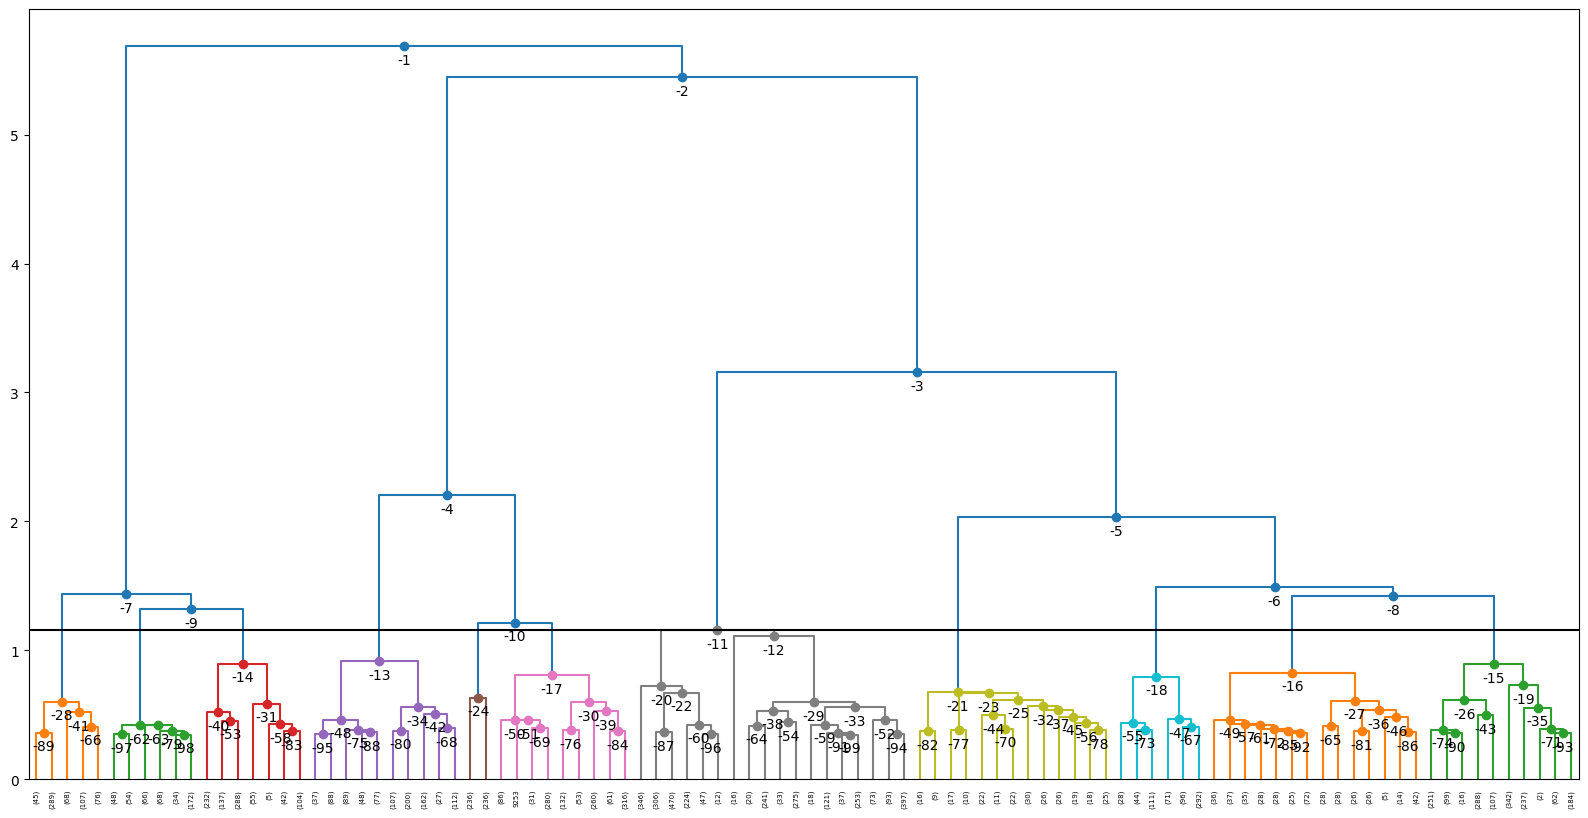

In [16]:
n_clusters=11 #the number of clusters known from the data

model_k = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward') #create the model

y_predict_hierarchical_k = model_k.fit_predict(X_train) #predict the clusters

plot_dendrogram(model=model_k, X=X_train, truncate_mode='lastp', p=100,
                n_clusters=n_clusters,
                color_threshold=None)

I repeat the process with n_clusters=3, since that is the amount of clusters known for DNA type.

(<Figure size 2000x1000 with 1 Axes>, <Axes: >)

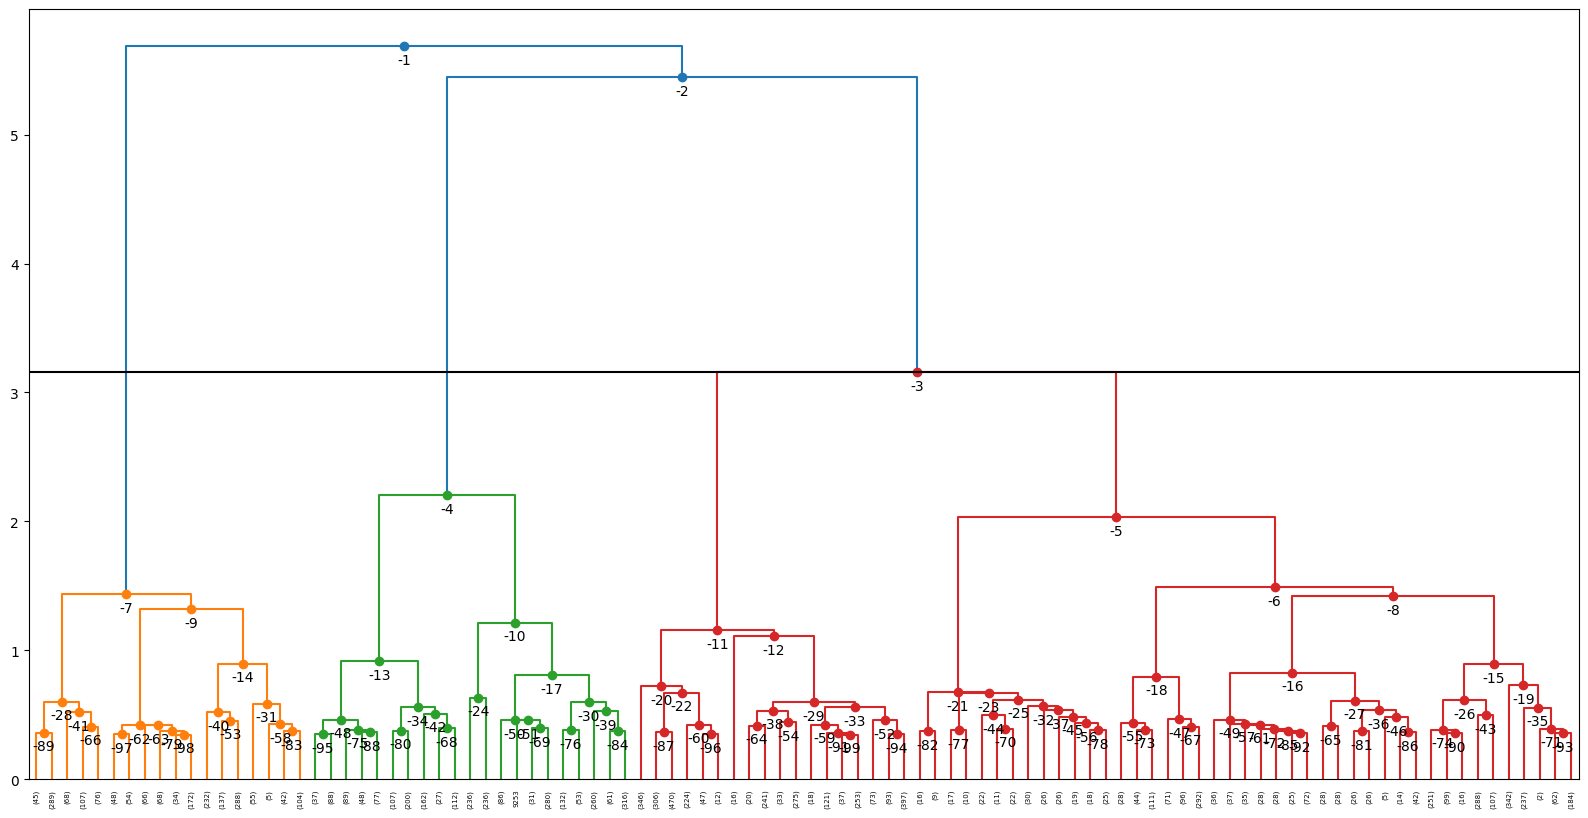

In [17]:
n_clusters=3 #the number of clusters known from the data

model_d = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward') #create the model

y_predict_hierarchical_d = model_d.fit_predict(X_train) #predict the clusters

plot_dendrogram(model=model_d, X=X_train, truncate_mode='lastp', p=100,
                n_clusters=n_clusters,
                color_threshold=None)

I also plot the predicted clusters in a 3d space.

In [18]:
fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=y_predict_hierarchical_k, labels={'color': 'Kingdom <br> Prediction'}
)
fig.update_traces(marker_size=8)

In [19]:
fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=y_predict_hierarchical_d, labels={'color': 'DNA Type <br> Prediction'}
)
fig.update_traces(marker_size=8)

Using the tot_purity function, I evaluate these predictions compared to both kingdom and DNA type classifications.

In [32]:
# the function inverse_tranform takes the one hot encoding and reverses it back to numbers, here ranging 0 to 10
print(tot_purity(y_predict_hierarchical_k, y_train_kingdom, X_train))
print(tot_purity(y_predict_hierarchical_d, y_train_dnatype, X_train))

0.5829015543969035
0.8918633659539363


The results indicate that the clustering is able to better model the DNA type rather than the kingdom.

### Kmeans


In [21]:
model_k = KMeans(n_clusters=11, init='random', random_state=0) #create the model
y_predict_km_k = model_k.fit_predict(X_train) #predict the clusters

fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=y_predict_km_k, labels={'color': 'Kingdom <br>Prediction'}
)
fig.update_traces(marker_size=8)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [22]:
model_d = KMeans(n_clusters=3, init='random', random_state=0) #create the model
y_predict_km_d = model_d.fit_predict(X_train) #predict the clusters

fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=y_predict_km_d, labels={'color': 'DNA Type <br>Prediction'}
)
fig.update_traces(marker_size=8)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



I once again use the tot_purity function previously defined to evaluate the performance, this time for Kmeans.

In [33]:
# the function inverse_tranform takes the one hot encoding and reverses it back to numbers, here ranging 0 to 10
print(tot_purity(y_predict_km_k, y_train_kingdom, X_train))
print(tot_purity(y_predict_km_d, y_train_dnatype, X_train))

0.5685089234243642
0.8926309729391836


Here, the results are similar to hierarchical clustering, in that the 3 cluster clustering for DNA type returns a better score.

### DBSCAN
Despite knowing the number of clusters I should have, you do not specify the number of clusters for DBSCAN, so I first use cross validation to determine the best values for its other parameters, eps and min_samples.

In [24]:
#define a make scorer function because DBSCAN uses fit_predict, rather than
def make_scorer(metric):
    def scorer(estimator, X, y):
        y_pred = estimator.fit_predict(X)
        return metric(y_pred, y, X)
    return scorer

In [26]:
#define the model
model = DBSCAN(eps=.1, min_samples=128)
#define the range of parameters
params = {'eps': [x / 10.0 for x in range(1,3)], 'min_samples': range(118,138)}
#cross validation for kingdom classification
cvk = GridSearchCV(model, params, scoring=make_scorer(tot_purity), cv=5)
cvk = cvk.fit(X_train, y_train_kingdom)
#cross validation for DNA type classification
cvd = GridSearchCV(model, params, scoring=make_scorer(tot_purity), cv=5)
cvd = cvd.fit(X_train, y_train_dnatype)

In [27]:
#the results regarding kingdom classification
print(cvk.best_params_)
pd.DataFrame(cvk.cv_results_)

{'eps': 0.2, 'min_samples': 118}


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_eps  \
0        0.477341      0.139204         0.109982        0.004356       0.1   
1        0.520072      0.195848         0.126852        0.022533       0.1   
2        0.400300      0.002775         0.101665        0.002531       0.1   
3        0.575062      0.195755         0.116760        0.021949       0.1   
4        0.405523      0.009494         0.103335        0.003065       0.1   
5        0.406677      0.007157         0.105048        0.003493       0.1   
6        0.405792      0.010365         0.103640        0.002919       0.1   
7        0.544734      0.184128         0.114793        0.014576       0.1   
8        0.403158      0.004296         0.102788        0.002545       0.1   
9        0.404797      0.002892         0.102097        0.001644       0.1   
10       0.403675      0.007430         0.103490        0.002637       0.1   
11       0.916586      0.255778         0.162347        0.011050       0.1   
12       0.783486      0.095292         0.143756        0.025979       0.1   
13       0.410604      0.009653         0.107433        0.011306       0.1   
14       0.518704      0.214209         0.110266        0.008828       0.1   
15       0.444315      0.076384         0.105696        0.008751       0.1   
16       0.403251      0.002980         0.102762        0.002045       0.1   
17       0.407185      0.004367         0.107757        0.013111       0.1   
18       0.711705      0.256593         0.138002        0.028120       0.1   
19       0.441943      0.051155         0.105968        0.003826       0.1   
20       0.941844      0.105377         0.122405        0.001202       0.2   
21       0.938744      0.106503         0.143747        0.026312       0.2   
22       0.901361      0.003713         0.123761        0.001764       0.2   
23       1.022488      0.249316         0.152078        0.036271       0.2   
24       1.028988      0.175099         0.150234        0.013310       0.2   
25       1.158365      0.217910         0.146672        0.023093       0.2   
26       1.168052      0.202246         0.153799        0.035365       0.2   
27       0.965404      0.138809         0.140005        0.023482       0.2   
28       0.887258      0.007164         0.122207        0.001425       0.2   
29       0.881609      0.006477         0.135982        0.027319       0.2   
30       0.946675      0.087343         0.123468        0.001488       0.2   
31       0.900905      0.007474         0.122841        0.001244       0.2   
32       0.962633      0.153038         0.134744        0.025937       0.2   
33       0.885173      0.007559         0.124660        0.003443       0.2   
34       1.010870      0.187944         0.138952        0.019995       0.2   
35       0.880401      0.003444         0.123243        0.001806       0.2   
36       0.920935      0.054627         0.132502        0.023926       0.2   
37       0.883357      0.002985         0.124133        0.002427       0.2   
38       0.885886      0.009441         0.132956        0.022488       0.2   
39       0.988339      0.200034         0.137519        0.026480       0.2   

   param_min_samples                            params  split0_test_score  \
0                118  {'eps': 0.1, 'min_samples': 118}           0.229257   
1                119  {'eps': 0.1, 'min_samples': 119}           0.229257   
2                120  {'eps': 0.1, 'min_samples': 120}           0.229257   
3                121  {'eps': 0.1, 'min_samples': 121}           0.229257   
4                122  {'eps': 0.1, 'min_samples': 122}           0.229257   
5                123  {'eps': 0.1, 'min_samples': 123}           0.229257   
6                124  {'eps': 0.1, 'min_samples': 124}           0.229257   
7                125  {'eps': 0.1, 'min_samples': 125}           0.229257   
8                126  {'eps': 0.1, 'min_samples': 126}           0.229257   
9                127  {'eps': 0.1, 

In [28]:
#the results regarding DNA type classification
print(cvd.best_params_)
pd.DataFrame(cvd.cv_results_)

{'eps': 0.2, 'min_samples': 118}


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_eps  \
0        0.419155      0.007976         0.039270        0.004319       0.1   
1        0.571500      0.207321         0.052791        0.016899       0.1   
2        0.414326      0.011401         0.050106        0.025944       0.1   
3        0.410573      0.006454         0.037045        0.000601       0.1   
4        0.740440      0.275985         0.072269        0.029015       0.1   
5        0.505553      0.159048         0.063163        0.030711       0.1   
6        0.453917      0.067305         0.041532        0.009065       0.1   
7        0.417150      0.010016         0.037017        0.001262       0.1   
8        0.408836      0.003514         0.037190        0.000638       0.1   
9        0.413397      0.010194         0.037275        0.000412       0.1   
10       0.495301      0.140396         0.057397        0.025428       0.1   
11       0.479264      0.104174         0.038263        0.002950       0.1   
12       0.413348      0.006067         0.036655        0.000798       0.1   
13       0.408757      0.007253         0.039694        0.004728       0.1   
14       0.409277      0.003168         0.038863        0.003240       0.1   
15       0.551818      0.161357         0.057634        0.023952       0.1   
16       0.432148      0.032185         0.037370        0.000507       0.1   
17       0.411389      0.004548         0.037217        0.000598       0.1   
18       0.567062      0.227166         0.069929        0.030636       0.1   
19       0.943171      0.127285         0.107237        0.003064       0.1   
20       1.008917      0.229938         0.060871        0.004370       0.2   
21       0.900311      0.004291         0.073419        0.026824       0.2   
22       0.932587      0.088322         0.058835        0.001326       0.2   
23       0.888030      0.003528         0.062749        0.009849       0.2   
24       0.944852      0.104837         0.068983        0.012568       0.2   
25       0.898637      0.008971         0.061338        0.005571       0.2   
26       0.967145      0.154786         0.082161        0.030671       0.2   
27       0.893754      0.018373         0.059425        0.001312       0.2   
28       0.881994      0.004589         0.058490        0.001068       0.2   
29       1.136242      0.214423         0.081950        0.022110       0.2   
30       0.897882      0.008658         0.063444        0.009493       0.2   
31       0.967342      0.142732         0.076367        0.025257       0.2   
32       0.891721      0.009634         0.058509        0.001254       0.2   
33       0.959891      0.129993         0.073333        0.019348       0.2   
34       0.884857      0.004649         0.058991        0.001902       0.2   
35       0.888390      0.006249         0.059141        0.002614       0.2   
36       0.964695      0.115151         0.078482        0.019960       0.2   
37       0.888430      0.012549         0.057685        0.000851       0.2   
38       0.964987      0.156472         0.077590        0.025988       0.2   
39       0.931962      0.102017         0.060175        0.001004       0.2   

   param_min_samples                            params  split0_test_score  \
0                118  {'eps': 0.1, 'min_samples': 118}           0.705036   
1                119  {'eps': 0.1, 'min_samples': 119}           0.704556   
2                120  {'eps': 0.1, 'min_samples': 120}           0.704556   
3                121  {'eps': 0.1, 'min_samples': 121}           0.704556   
4                122  {'eps': 0.1, 'min_samples': 122}           0.704556   
5                123  {'eps': 0.1, 'min_samples': 123}           0.704556   
6                124  {'eps': 0.1, 'min_samples': 124}           0.704556   
7                125  {'eps': 0.1, 'min_samples': 125}           0.704556   
8                126  {'eps': 0.1, 'min_samples': 126}           0.704556   
9                127  {'eps': 0.1, 

The cross validation chooses eps=0.2 and min_samples=118 as those producing the best model, so I use these to build the model.

In [29]:
#create the model
model = DBSCAN(eps=0.2, min_samples=118)
y_predict_db = model.fit_predict(X_train) #fit and predict the clusters

#visualize
fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=y_predict_db, labels={'color': 'Prediction'}
)
fig.update_traces(marker_size=8)

The visualization shows that DBSCAN performs rather poorly. I can asses this evaluation using the tot_purity function.

In [31]:
print(tot_purity(y_predict_db, y_train_kingdom, X_train))
print(tot_purity(y_predict_db, y_train_dnatype, X_train))

0.224141239685066
0.7105162156968808


Given the purity scores from all three models, it can be said that hierarchical clustering produces the best results given this data. However, it cannot be said that the data clusters into classes that are easily identifiable.

# Classification
Using the codon frequencies, I use several different classification model types to attempt to predict both kingdom and DNA type classifications.

First, I define an accuracy function, which will be used as a scoring metric for the classifiers.

In [17]:
#accuracy= n_correct/n_total
def accuracy(y_pred, y_true):
    return (y_pred==y_true).sum()/len(y_true)

## Features Selection

## Logistic Regression

TODO: possible solvers are saga, sag, newton-cg, and lbfgs. Saga and sag can handle large datasets, so maybe stick to saga. Possible penalties are l1, l2, elasticnet, or none. Using gridsearchcv, test every possible combo of penalty and c vals (lasso) from a range of c vals. Also define an accuracy function to use as a scorer.

### Features Selection
First, I use GridSearchCV to find the optimal penalty and value of C for each type of classification. As I saw in the data visualization, the classes are highly skewed, so to account for this I set class_weight to balanced and use the F1 score as my metric, rather than accuracy.

*Warning!* This code takes quite a while to run (132 minutes on my computer). For the sake of grading, I recommend not running it, I list the results below.

In [20]:
#normalize the data
scaler=StandardScaler()
X_train_std = scaler.fit_transform(X_train)

#define the model
#because the classes are highly skewed, I set the class weight to balanced so the model considers the classes with less samples
model = LogisticRegression(solver='saga', penalty='l2', C=0.1, max_iter=8000, multi_class='multinomial', class_weight='balanced')

#define the range of parameters
#because some of the features are highly correlated, the model has difficulty converging at certain values of C
params = {'solver':['saga'],'penalty':['l1','l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],#[x / 10.0 for x in range(1,6)],
          'max_iter':[8000], 'multi_class':['multinomial'], 'class_weight':['balanced']}
#cross validation for kingdom classification
cvk = GridSearchCV(model, params, scoring=sklearn.metrics.make_scorer(accuracy), cv=3, n_jobs=12) #specify which make_scorer, because I previously overwrote it as a function
cvk = cvk.fit(X_train_std, y_train_kingdom)
#cross validation for DNA type classification
#this cross validation will throw out several warning because the classes are extremely skewed
cvd = GridSearchCV(model, params, scoring=sklearn.metrics.make_scorer(accuracy), cv=3, n_jobs=12)
cvd = cvd.fit(X_train_std, y_train_dnatype)

KeyboardInterrupt: 

In [ ]:
#the results regarding kingdom classification
print(cvk.best_params_)
pd.DataFrame(cvk.cv_results_)

{'C': 100, 'class_weight': 'balanced', 'max_iter': 5000, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga'}


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0        1.171552      0.222429         0.034452        0.008150   0.001   
1        2.110740      0.503119         0.033269        0.007384   0.001   
2        4.299891      1.494766         0.036977        0.004865    0.01   
3       20.073103     22.261324         0.031793        0.004283    0.01   
4       26.156524      5.937900         0.031024        0.002511     0.1   
5       12.621989      4.161269         0.027292        0.006374     0.1   
6       97.184184     33.568428         0.025381        0.001877       1   
7       40.669207     11.597372         0.034746        0.005799       1   
8      156.832668     13.030625         0.030240        0.003722      10   
9       98.859991     12.583127         0.017169        0.010890      10   
10     163.682842     12.825704         0.002374        0.000387     100   
11     124.611930     10.351706         0.002046        0.000174     100   
12     166.671790     14.047137         0.001926        0.000146    1000   
13     124.173186      8.260919         0.003849        0.001653    1000   

   param_class_weight param_max_iter param_multi_class param_penalty  \
0            balanced           5000       multinomial            l1   
1            balanced           5000       multinomial            l2   
2            balanced           5000       multinomial            l1   
3            balanced           5000       multinomial            l2   
4            balanced           5000       multinomial            l1   
5            balanced           5000       multinomial            l2   
6            balanced           5000       multinomial            l1   
7            balanced           5000       multinomial            l2   
8            balanced           5000       multinomial            l1   
9            balanced           5000       multinomial            l2   
10           balanced           5000       multinomial            l1   
11           balanced           5000       multinomial            l2   
12           balanced           5000       multinomial            l1   
13           balanced           5000       multinomial            l2   

   param_solver                                             params  \
0          saga  {'C': 0.001, 'class_weight': 'balanced', 'max_...   
1          saga  {'C': 0.001, 'class_weight': 'balanced', 'max_...   
2          saga  {'C': 0.01, 'class_weight': 'balanced', 'max_i...   
3          saga  {'C': 0.01, 'class_weight': 'balanced', 'max_i...   
4          saga  {'C': 0.1, 'class_weight': 'balanced', 'max_it...   
5          saga  {'C': 0.1, 'class_weight': 'balanced', 'max_it...   
6          saga  {'C': 1, 'class_weight': 'balanced', 'max_iter...   
7          saga  {'C': 1, 'class_weight': 'balanced', 'max_iter...   
8          saga  {'C': 10, 'class_weight': 'balanced', 'max_ite...   
9          saga  {'C': 10, 'class_weight': 'balanced', 'max_ite...   
10         saga  {'C': 100, 'class_weight': 'balanced', 'max_it...   
11         saga  {'C': 100, 'class_weight': 'balanced', 'max_it...   
12         saga  {'C': 1000, 'class_weight': 'balanced', 'max_i...   
13         saga  {'C': 1000, 'class_weight': 'balanced', 'max_i...   

    split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0            0.124640           0.057858           0.057571         0.080023   
1            0.620322           0.638457           0.638745         0.632508   
2            0.597006           0.601900           0.609096         0.602667   
3            0.736327           0.746690           0.753886         0.745634   
4            0.770869           0.779793           0.784974         0.778545   
5            0.786989           0.785262           0.784974         0.785742   
6            0.794761           0.792170           0.793034         0.793322   
7            0.794185           0.791595           0.794473         0.793418   
8          

In [ ]:
#the results regarding DNA type classification
print(cvd.best_params_)
pd.DataFrame(cvd.cv_results_)

{'C': 100, 'class_weight': 'balanced', 'max_iter': 5000, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'saga'}


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0      173.371389      4.399739         0.002904        0.000670   0.001   
1      137.776613      5.241533         0.003788        0.001764   0.001   
2      170.883328      8.632952         0.002677        0.000507    0.01   
3      136.466673      6.144087         0.002876        0.000436    0.01   
4       98.537532     41.468051         0.003447        0.002501     0.1   
5       55.083306     51.798119         0.001969        0.000384     0.1   
6      138.618060     30.087023         0.002344        0.000607       1   
7       68.248736     22.582425         0.001920        0.000454       1   
8      101.438037     16.643390         0.001869        0.000207      10   
9       89.772311     16.522561         0.001992        0.000209      10   
10      91.990724     15.147353         0.002346        0.001014     100   
11      76.172142     16.278366         0.001576        0.000087     100   
12     106.162672     40.147938         0.038247        0.004187    1000   
13      66.743986     10.865014         0.032815        0.001727    1000   

   param_class_weight param_max_iter param_multi_class param_penalty  \
0            balanced           5000       multinomial            l1   
1            balanced           5000       multinomial            l2   
2            balanced           5000       multinomial            l1   
3            balanced           5000       multinomial            l2   
4            balanced           5000       multinomial            l1   
5            balanced           5000       multinomial            l2   
6            balanced           5000       multinomial            l1   
7            balanced           5000       multinomial            l2   
8            balanced           5000       multinomial            l1   
9            balanced           5000       multinomial            l2   
10           balanced           5000       multinomial            l1   
11           balanced           5000       multinomial            l2   
12           balanced           5000       multinomial            l1   
13           balanced           5000       multinomial            l2   

   param_solver                                             params  \
0          saga  {'C': 0.001, 'class_weight': 'balanced', 'max_...   
1          saga  {'C': 0.001, 'class_weight': 'balanced', 'max_...   
2          saga  {'C': 0.01, 'class_weight': 'balanced', 'max_i...   
3          saga  {'C': 0.01, 'class_weight': 'balanced', 'max_i...   
4          saga  {'C': 0.1, 'class_weight': 'balanced', 'max_it...   
5          saga  {'C': 0.1, 'class_weight': 'balanced', 'max_it...   
6          saga  {'C': 1, 'class_weight': 'balanced', 'max_iter...   
7          saga  {'C': 1, 'class_weight': 'balanced', 'max_iter...   
8          saga  {'C': 10, 'class_weight': 'balanced', 'max_ite...   
9          saga  {'C': 10, 'class_weight': 'balanced', 'max_ite...   
10         saga  {'C': 100, 'class_weight': 'balanced', 'max_it...   
11         saga  {'C': 100, 'class_weight': 'balanced', 'max_it...   
12         saga  {'C': 1000, 'class_weight': 'balanced', 'max_i...   
13         saga  {'C': 1000, 'class_weight': 'balanced', 'max_i...   

    split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0            0.390904           0.245826           0.270581         0.302437   
1            0.574266           0.647093           0.505469         0.575609   
2            0.864709           0.822971           0.631836         0.773172   
3            0.832758           0.947323           0.889465         0.889848   
4            0.941854           0.951641           0.957974         0.950489   
5            0.960564           0.964882           0.922568         0.949338   
6            0.966033           0.971790           0.971215         0.969680   
7            0.971503           0.973518           0.968336         0.971119   
8          

The features selection gives as best parameters C=100, l1 penalty for kingdom classification, and l2 penalty for DNA type classification.

### Training Score
Now I can use cross validation again, this time to assess the accuracy of the model on the training data using these parameters.

In [ ]:
#create the model
model = LogisticRegression(solver='saga', penalty='l1', C=100, max_iter=5000, multi_class='multinomial', class_weight='balanced')
#cross validation
scores = cross_val_score(model, X_train, y_train_kingdom, cv=3, scoring=sklearn.metrics.make_scorer(accuracy))
#take the mean of the scores for each iteration
kingdom_val_score=np.mean(scores)
#repeat for DNA type
model = LogisticRegression(solver='saga', penalty='l2', C=100, max_iter=5000, multi_class='multinomial', class_weight='balanced')
scores = cross_val_score(model, X_train, y_train_dnatype, cv=3, scoring=sklearn.metrics.make_scorer(accuracy))
dna_val_score=np.mean(scores)

/home/fbazzi19/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/home/fbazzi19/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/home/fbazzi19/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/home/fbazzi19/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.

/home/fbazzi19/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/home/fbazzi19/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reache

In [ ]:
print("Validation score for Kingdom classification: ", kingdom_val_score)
print("Validation score for DNA type classification: ", dna_val_score)

Validation score for Kingdom classification:  0.6940126655152561
Validation score for DNA type classification:  0.3821723277681827


These scores, along with the fact that the model fails to converge, indicate that the logistic regression classifier may not be well suited for this data.

*Note:* Although not shown here, I would like it to be known that I attempted to increase the maximum iterations parameter up to 10,000 in order to resolve the model's failure to converge, but was not successful. After some investigation into scikit learns documentation and stack exchange forums, I have come to the conclusion that the problem lies within the data itself, and it's incompatability with the logistic regression model.

## Linear Discriminant Analysis

### Features Selection
First, I use cross validation to determine the degree to which features should be projected into a higher dimension in order to obtain a polynomial boundary.

In [ ]:
model = Pipeline([('poly', PolynomialFeatures()),
                  ('lda', LDA(store_covariance=True))])
params = {'poly__degree': range(1, 6)}
#cross validation for kingdom classification
cvk = GridSearchCV(model, params,  refit=True, scoring=sklearn.metrics.make_scorer(accuracy), cv=3) #specify which make_scorer, because I previously overwrote it as a function
cvk = cvk.fit(X_train, y_train_kingdom)
#cross validation for DNA type classification
cvd = GridSearchCV(model, params,  refit=True, scoring=sklearn.metrics.make_scorer(accuracy), cv=3)
cvd = cvd.fit(X_train, y_train_dnatype)

/home/fbazzi19/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning:


9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fbazzi19/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/fbazzi19/.local/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/fbazzi19/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y, **last_step

In [ ]:
#the results regarding kingdom classification
print(cvk.best_params_)
pd.DataFrame(cvk.cv_results_)

{'poly__degree': 2}


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.268072      0.140286         0.022022        0.011406   
1      16.686462      3.034606         0.094174        0.014690   
2       6.274332      2.154760         0.000000        0.000000   
3       0.005167      0.000725         0.000000        0.000000   
4       0.005468      0.000896         0.000000        0.000000   

  param_poly__degree               params  split0_test_score  \
0                  1  {'poly__degree': 1}           0.794185   
1                  2  {'poly__degree': 2}           0.899827   
2                  3  {'poly__degree': 3}                NaN   
3                  4  {'poly__degree': 4}                NaN   
4                  5  {'poly__degree': 5}                NaN   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.781808           0.789004         0.788332        0.005075   
1           0.904433           0.898964         0.901075        0.002401   
2                NaN                NaN              NaN             NaN   
3                NaN                NaN              NaN             NaN   
4                NaN                NaN              NaN             NaN   

   rank_test_score  
0                2  
1                1  
2                3  
3                3  
4                3

In [ ]:
#the results regarding DNA type classification
print(cvd.best_params_)
pd.DataFrame(cvd.cv_results_)

{'poly__degree': 2}


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.083893      0.007717         0.010077        0.007886   
1      17.063074      2.488848         0.140960        0.016678   
2       4.519779      0.102315         0.000000        0.000000   
3       0.005313      0.000240         0.000000        0.000000   
4       0.004896      0.000373         0.000000        0.000000   

  param_poly__degree               params  split0_test_score  \
0                  1  {'poly__degree': 1}           0.973805   
1                  2  {'poly__degree': 2}           0.983880   
2                  3  {'poly__degree': 3}                NaN   
3                  4  {'poly__degree': 4}                NaN   
4                  5  {'poly__degree': 5}                NaN   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.974957           0.968624         0.972462        0.002754   
1           0.984744           0.987622         0.985415        0.001600   
2                NaN                NaN              NaN             NaN   
3                NaN                NaN              NaN             NaN   
4                NaN                NaN              NaN             NaN   

   rank_test_score  
0                2  
1                1  
2                3  
3                3  
4                3

Due to the size of the data and memory constrains, a degree higher than 2 is not well handled, so the best parameters indicated by cross validation is degree=2.

### Training Score
I can now use this parameter to test the accuracy of the model.

In [ ]:
#create the model
model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('lda', LDA(store_covariance=True))])
#cross validation
scores = cross_val_score(model, X_train, y_train_kingdom, cv=5, scoring=sklearn.metrics.make_scorer(accuracy))
#take the mean of the scores for each iteration
kingdom_val_score=np.mean(scores)
#repeat for DNA type
#because the classes are highly skewed, this throws several warnings
scores = cross_val_score(model, X_train, y_train_dnatype, cv=5, scoring=sklearn.metrics.make_scorer(accuracy))
dna_val_score=np.mean(scores)

/home/fbazzi19/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

/home/fbazzi19/.local/lib/python3.10/site-packages/sklearn/covariance/_empirical_covariance.py:102: UserWarning:

Only one sample available. You may want to reshape your data array

/home/fbazzi19/.local/lib/python3.10/site-packages/sklearn/covariance/_empirical_covariance.py:102: UserWarning:

Only one sample available. You may want to reshape your data array

/home/fbazzi19/.local/lib/python3.10/site-packages/sklearn/covariance/_empirical_covariance.py:102: UserWarning:

Only one sample available. You may want to reshape your data array

/home/fbazzi19/.local/lib/python3.10/site-packages/sklearn/covariance/_empirical_covariance.py:102: UserWarning:

Only one sample available. You may want to reshape your data array

/home/fbazzi19/.local/lib/python3.10/site-packages/sklearn/covariance/_empirical_cova

In [ ]:
print("Validation score for Kingdom classification: ", kingdom_val_score)
print("Validation score for DNA type classification: ", dna_val_score)

Validation score for Kingdom classification:  0.905968369258528
Validation score for DNA type classification:  0.9859912914198391


These validation scores indicate that the LDA model (with polynomial features) is able to classify the data remarkably well. However, this can be attributed to the skewed classes. For example, given the sheer amount of samples having DNA type '0', a classifier which only ever predicts '0' for DNA type would still have a relatively high accuracy.

## K-Nearest Neighbors

### Features Selection
First, I perform cross validation to determine the best number of K neighbors to consider in the model.

In [ ]:
#define the model
model = KNeighborsClassifier()

#define the range of parameters
params = {'n_neighbors': range(1, 15)}

#cross validation for kingdom classification
cvk = GridSearchCV(model, params, scoring=sklearn.metrics.make_scorer(accuracy), cv=10) #specify which make_scorer, because I previously overwrote it as a function
cvk = cvk.fit(X_train, y_train_kingdom)
#cross validation for DNA type classification
cvd = GridSearchCV(model, params, scoring=sklearn.metrics.make_scorer(accuracy), cv=10)
cvd = cvd.fit(X_train, y_train_dnatype)

/home/fbazzi19/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.



In [ ]:
#the results regarding kingdom classification
print(cvk.best_params_)
pd.DataFrame(cvk.cv_results_)

{'n_neighbors': 3}


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.019691      0.003309         0.079740        0.013372   
1        0.015991      0.001777         0.083022        0.015423   
2        0.015419      0.000547         0.086351        0.014925   
3        0.014919      0.000468         0.076762        0.004222   
4        0.015083      0.000591         0.081003        0.012146   
5        0.015437      0.000841         0.087068        0.020512   
6        0.015397      0.000654         0.082275        0.012570   
7        0.014644      0.001173         0.080717        0.016466   
8        0.011957      0.001006         0.057514        0.004187   
9        0.011208      0.000910         0.052925        0.001642   
10       0.011007      0.000409         0.051590        0.001617   
11       0.011192      0.000299         0.053743        0.002478   
12       0.010822      0.000335         0.052658        0.001468   
13       0.011113      0.000673         0.067640        0.016217   

   param_n_neighbors               params  split0_test_score  \
0                  1   {'n_neighbors': 1}           0.838926   
1                  2   {'n_neighbors': 2}           0.816874   
2                  3   {'n_neighbors': 3}           0.850431   
3                  4   {'n_neighbors': 4}           0.844679   
4                  5   {'n_neighbors': 5}           0.849473   
5                  6   {'n_neighbors': 6}           0.845638   
6                  7   {'n_neighbors': 7}           0.855225   
7                  8   {'n_neighbors': 8}           0.843720   
8                  9   {'n_neighbors': 9}           0.853308   
9                 10  {'n_neighbors': 10}           0.846596   
10                11  {'n_neighbors': 11}           0.846596   
11                12  {'n_neighbors': 12}           0.843720   
12                13  {'n_neighbors': 13}           0.844679   
13                14  {'n_neighbors': 14}           0.838926   

    split1_test_score  split2_test_score  split3_test_score  \
0            0.848514           0.824376           0.821497   
1            0.808245           0.797505           0.809981   
2            0.844679           0.822457           0.841651   
3            0.839885           0.818618           0.824376   
4            0.855225           0.830134           0.835893   
5            0.854267           0.828215           0.831094   
6            0.854267           0.828215           0.829175   
7            0.852349           0.833973           0.822457   
8            0.859060           0.833973           0.825336   
9            0.850431           0.823417           0.827255   
10           0.849473           0.832054           0.832054   
11           0.843720           0.824376           0.823417   
12           0.839885           0.826296           0.831094   
13           0.838926           0.820537           0.816699   

    split4_test_score  split5_test_score  split6_test_score  \
0            0.847409           0.833013           0.847409   
1            0.832054           0.817658           0.825336   
2            0.867562           0.840691           0.857006   
3            0.853167           0.830134           0.851248   
4            0.860845           0.837812           0.837812   
5            0.857006           0.823417           0.839731   
6            0.857006           0.822457           0.844530   
7            0.857965           0.827255           0.836852   
8            0.853167           0.827255           0.837812   
9            0.851248           0.822457           0.833973   
10           0.848369           0.832054           0.834933   
11           0.848369           0.831094           0.834933   
12           0.844530           0.825336           0.836852   
13           0.843570           0.822457           0.832054   

    split7_test_score  split8_test_score  split9_test_score  mean_test_score  \
0            0.829175           0.843570          

In [ ]:
#the results regarding DNA type classification
print(cvd.best_params_)
pd.DataFrame(cvd.cv_results_)

{'n_neighbors': 2}


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.005792      0.000770         0.053127        0.004748   
1        0.005382      0.000291         0.051988        0.000978   
2        0.005541      0.000445         0.051064        0.001968   
3        0.006130      0.001469         0.054648        0.003504   
4        0.005420      0.000381         0.051236        0.002347   
5        0.005659      0.000554         0.052683        0.003092   
6        0.005658      0.000606         0.052284        0.002293   
7        0.005432      0.000461         0.052086        0.001569   
8        0.005417      0.000285         0.053055        0.003724   
9        0.005574      0.000416         0.055050        0.003314   
10       0.005833      0.000508         0.057862        0.008383   
11       0.005920      0.000628         0.054324        0.001641   
12       0.005517      0.000392         0.053081        0.002320   
13       0.005406      0.000360         0.056475        0.005662   

   param_n_neighbors               params  split0_test_score  \
0                  1   {'n_neighbors': 1}           0.979866   
1                  2   {'n_neighbors': 2}           0.983701   
2                  3   {'n_neighbors': 3}           0.980825   
3                  4   {'n_neighbors': 4}           0.983701   
4                  5   {'n_neighbors': 5}           0.983701   
5                  6   {'n_neighbors': 6}           0.983701   
6                  7   {'n_neighbors': 7}           0.983701   
7                  8   {'n_neighbors': 8}           0.982742   
8                  9   {'n_neighbors': 9}           0.982742   
9                 10  {'n_neighbors': 10}           0.981783   
10                11  {'n_neighbors': 11}           0.983701   
11                12  {'n_neighbors': 12}           0.983701   
12                13  {'n_neighbors': 13}           0.983701   
13                14  {'n_neighbors': 14}           0.982742   

    split1_test_score  split2_test_score  split3_test_score  \
0            0.981783           0.977927           0.978887   
1            0.984660           0.975048           0.984645   
2            0.981783           0.976008           0.986564   
3            0.981783           0.976008           0.984645   
4            0.983701           0.974088           0.982726   
5            0.982742           0.971209           0.984645   
6            0.982742           0.971209           0.981766   
7            0.982742           0.973129           0.979846   
8            0.981783           0.972169           0.979846   
9            0.984660           0.975048           0.980806   
10           0.983701           0.975048           0.980806   
11           0.984660           0.974088           0.979846   
12           0.983701           0.974088           0.979846   
13           0.983701           0.972169           0.980806   

    split4_test_score  split5_test_score  split6_test_score  \
0            0.984645           0.976967           0.979846   
1            0.982726           0.976967           0.982726   
2            0.987524           0.977927           0.977927   
3            0.984645           0.975048           0.980806   
4            0.985605           0.973129           0.979846   
5            0.985605           0.974088           0.980806   
6            0.985605           0.974088           0.979846   
7            0.986564           0.974088           0.981766   
8            0.985605           0.975048           0.977927   
9            0.985605           0.974088           0.979846   
10           0.987524           0.974088           0.978887   
11           0.985605           0.975048           0.979846   
12           0.986564           0.974088           0.979846   
13           0.985605           0.974088           0.979846   

    split7_test_score  split8_test_score  split9_test_score  mean_test_score  \
0            0.978887           0.983685          

Cross validation indicates that the best value of k is 3 for Kingdom classification and 2 for DNA type classification.

### Training Score
Now I can use cross validation once again, this time to get the validation score on the training data.

In [ ]:
#create the model
model_k = KNeighborsClassifier(n_neighbors=3)
#cross validation
scores = cross_val_score(model_k, X_train, y_train_kingdom, cv=5, scoring=sklearn.metrics.make_scorer(accuracy))
#take the mean of the scores for each iteration
kingdom_val_score=np.mean(scores)
#repeat for DNA type
model_d = KNeighborsClassifier(n_neighbors=2)
scores = cross_val_score(model_d, X_train, y_train_dnatype, cv=5, scoring=sklearn.metrics.make_scorer(accuracy))
dna_val_score=np.mean(scores)

/home/fbazzi19/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



In [ ]:
print("Validation score for Kingdom classification: ", kingdom_val_score)
print("Validation score for DNA type classification: ", dna_val_score)

Validation score for Kingdom classification:  0.839571107029923
Validation score for DNA type classification:  0.981193655440331


I can visualize how the classifications are arranged and any misclassifications, by reducing the dimensionality down to 2D.

In [ ]:
#change settings so only the last figure is shown, reverted after these figures
InteractiveShell.ast_node_interactivity = "last"

In [ ]:
#reduce dimensionality to 2 for visualization
tsne = TSNE(n_components=2, random_state=0)
projections_2d = tsne.fit_transform(X_train, )

#fit the model and predict
model_k=model_k.fit(X_train, y_train_kingdom)
y_pred=model_k.predict(X_train)
#produce the plot
fig = px.scatter(
    projections_2d, x=0, y=1,
    color=y_pred,
    symbol=y_train_kingdom,
    labels={'symbol': 'True', 'color': 'Prediction'}
)
fig.update_traces(marker_size=12, marker_line_width=1.5)
fig.update_layout(legend_orientation='h')


In [ ]:
#fit the model and predict
model_d=model_d.fit(X_train, y_train_dnatype)
y_pred=model_d.predict(X_train)
#produce the plot
fig = px.scatter(
    projections_2d, x=0, y=1,
    color=y_pred,
    symbol=y_train_dnatype,
    labels={'symbol': 'True', 'color': 'Prediction'}
)
fig.update_traces(marker_size=12, marker_line_width=1.5)
fig.update_layout(legend_orientation='h')

In [ ]:
InteractiveShell.ast_node_interactivity = "all"

The validation scores show that the K-nearest neighbors model also does remarkably well on the data, which the figures also indicate, although the density of the points may make it hard to interpret. However, this performance may once again be attributed to the skewed classes.

## Support Vector Machine

### Features Selection
First I use cross validation to determine the best kernel and parameters for the model.

In [ ]:
# Polynomial
param_grid = {'C': np.linspace(0.001, 100, 5),
              'coef0': np.linspace(-10, 10, 5),
              'degree': [2, 3, 4]}
#Kingdom
cvk_svm = GridSearchCV(SVC(kernel='poly', class_weight='balanced'), param_grid,
                        cv=5, scoring=sklearn.metrics.make_scorer(accuracy), refit=True)
cvk_svm=cvk_svm.fit(X_train, y_train_kingdom)
#dna type
cvd_svm = GridSearchCV(SVC(kernel='poly', class_weight='balanced'), param_grid,
                        cv=5, scoring=sklearn.metrics.make_scorer(accuracy), refit=True)
cvd_svm=cvd_svm.fit(X_train, y_train_dnatype)

/home/fbazzi19/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



In [ ]:
# RBF
param_grid = {'C': np.linspace(0.001, 100, 5),
              'gamma': np.linspace(0.001, 100, 5)}
#kingdom
cvk_rbf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid,
                        cv=5, scoring=sklearn.metrics.make_scorer(accuracy), refit=True)
cvk_rbf=cvk_rbf.fit(X_train, y_train_kingdom)
#dna type
cvd_rbf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid,
                        cv=5, scoring=sklearn.metrics.make_scorer(accuracy), refit=True)
cvd_rbf=cvd_rbf.fit(X_train, y_train_dnatype)

/home/fbazzi19/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



*Warning!* This code took approximately 6 hours to run on my computer.

In [ ]:
# Sigmoid
param_grid = {'C': np.linspace(0.001, 100, 5),
              'gamma': np.linspace(0.001, 100, 5),
              'coef0': np.linspace(-10, 10, 5)}
#kingdom
cvk_sigm = GridSearchCV(SVC(kernel='sigmoid', class_weight='balanced'), param_grid,
                         cv=5, scoring=sklearn.metrics.make_scorer(accuracy), refit=True)
cvk_sigm = cvk_sigm.fit(X_train, y_train_kingdom)
#dna type
cvd_sigm = GridSearchCV(SVC(kernel='sigmoid', class_weight='balanced'), param_grid,
                         cv=5, scoring=sklearn.metrics.make_scorer(accuracy), refit=True)
cvd_sigm = cvd_sigm.fit(X_train, y_train_dnatype)

/home/fbazzi19/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



Now I check the scores of the best estimators for each kernel type. Because of the high amount of features the SVM was trained on, I cannot unfortunately plot the SVM boundary within the 2d space, but I instead indicate the predictions of the boundary using the color of the points.

<Figure size 640x480 with 0 Axes>

SVC(C=25.00075, class_weight='balanced', degree=2, kernel='poly')


<Axes: >

cv score: 0.904528921967992
train score: 0.985895221646517



<Figure size 640x480 with 0 Axes>

SVC(C=25.00075, class_weight='balanced', gamma=100.0)


<Axes: >

cv score: 0.9185372623206618
train score: 0.9963538668201881



<Figure size 640x480 with 0 Axes>

SVC(C=100.0, class_weight='balanced', coef0=-5.0, gamma=100.0, kernel='sigmoid')


<Axes: >

cv score: 0.8720977920159074
train score: 0.9197850700441375



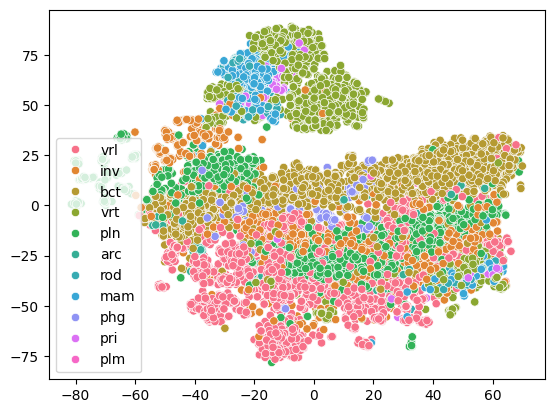

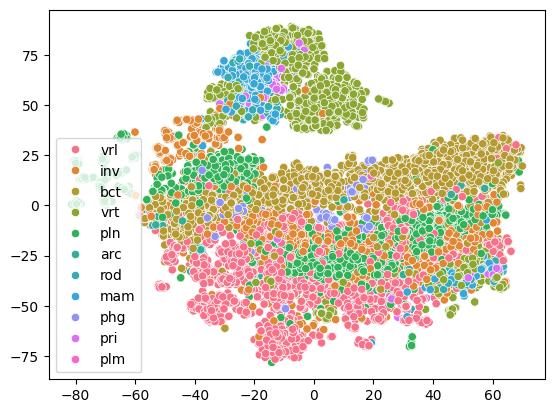

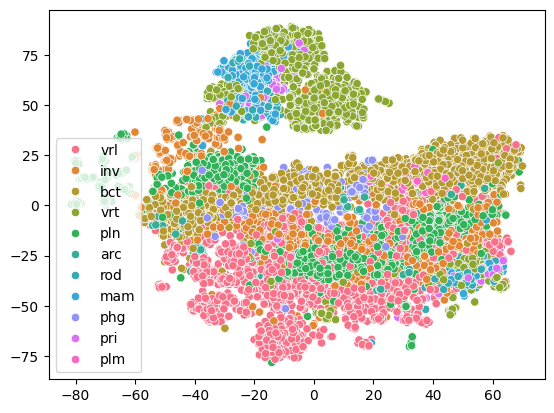

In [ ]:
for m in [cvk_svm, cvk_rbf, cvk_sigm]:
    cv_score = m.best_score_
    m = m.best_estimator_
    plt.figure()
    print(m)
    m=m.fit(X_train, y_train_kingdom)
    sns.scatterplot(x=projections_2d[:,0], y=projections_2d[:,1], hue=m.predict(X_train), marker='o')
    train_acc = accuracy(m.predict(X_train), y_train_kingdom)
    print("cv score: {}".format(cv_score))
    print("train score: {}\n".format(train_acc))

<Figure size 640x480 with 0 Axes>

SVC(C=25.00075, class_weight='balanced', degree=2, kernel='poly')


<Axes: >

cv score: 0.9884859406141114
train score: 0.9984647860295529



<Figure size 640x480 with 0 Axes>

SVC(C=25.00075, class_weight='balanced', gamma=75.00025)


<Axes: >

cv score: 0.9901173725127383
train score: 0.9987526386490118



<Figure size 640x480 with 0 Axes>

SVC(C=100.0, class_weight='balanced', coef0=-5.0, gamma=100.0, kernel='sigmoid')


<Axes: >

cv score: 0.980042530275204
train score: 0.9881980426021877



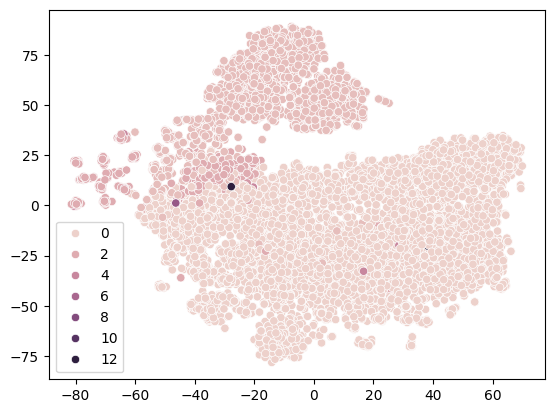

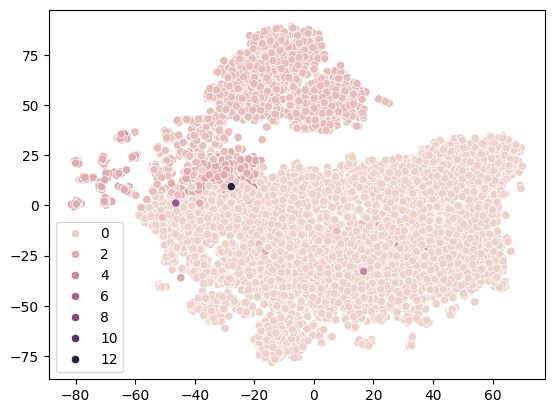

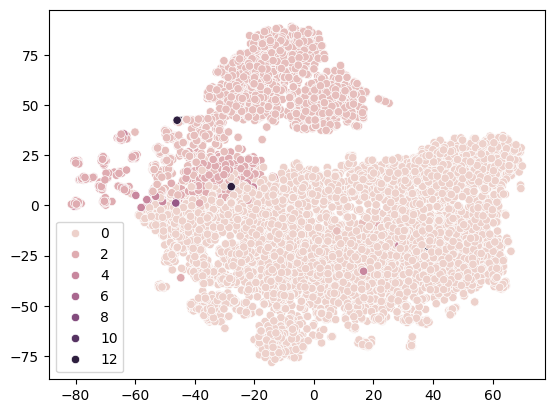

In [ ]:
for m in [cvd_svm, cvd_rbf, cvd_sigm]:
    cv_score = m.best_score_
    m = m.best_estimator_
    plt.figure()
    print(m)
    m=m.fit(X_train, y_train_dnatype)
    sns.scatterplot(x=projections_2d[:,0], y=projections_2d[:,1], hue=m.predict(X_train), marker='o')
    train_acc = accuracy(m.predict(X_train), y_train_dnatype)
    print("cv score: {}".format(cv_score))
    print("train score: {}\n".format(train_acc))

These results indicate that for both kingdom and DNA type classifications, the rbf kernel should be chosen. For kingdom classification, the best parameters are SVC(C=25.00075, class_weight='balanced', gamma=100.0), and for DNA type classification, the best parameters are SVC(C=25.00075, class_weight='balanced', gamma=75.00025).


### Training Score
Now, I use these parameters